### KR1

@code_native prints the native assembly instructions in the lowest level. This gives us insight on how much memory/computing power is used to perform a task. For example using code_native on addition showed less steps than that on division. This means that division is more taxing to our machine than division. 

In [1]:
@code_native 1+1

	.text
	.file	"+"
	.globl	"julia_+_1077"                  # -- Begin function julia_+_1077
	.p2align	4, 0x90
	.type	"julia_+_1077",@function
"julia_+_1077":                         # @"julia_+_1077"
; ┌ @ int.jl:87 within `+`
	.cfi_startproc
# %bb.0:                                # %top
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset %rbp, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register %rbp
	leaq	(%rcx,%rdx), %rax
	popq	%rbp
	retq
.Lfunc_end0:
	.size	"julia_+_1077", .Lfunc_end0-"julia_+_1077"
	.cfi_endproc
; └
                                        # -- End function
	.section	".note.GNU-stack","",@progbits


In [2]:
@code_native 1/1

	.text
	.file	"/"
	.globl	"julia_/_1142"                  # -- Begin function julia_/_1142
	.p2align	4, 0x90
	.type	"julia_/_1142",@function
"julia_/_1142":                         # @"julia_/_1142"
; ┌ @ int.jl:97 within `/`
	.cfi_startproc
# %bb.0:                                # %top
	pushq	%rbp
	.cfi_def_cfa_offset 16
	.cfi_offset %rbp, -16
	movq	%rsp, %rbp
	.cfi_def_cfa_register %rbp
; │┌ @ float.jl:269 within `float`
; ││┌ @ float.jl:243 within `AbstractFloat`
; │││┌ @ float.jl:146 within `Float64`
	vcvtsi2sd	%rcx, %xmm0, %xmm0
	vcvtsi2sd	%rdx, %xmm1, %xmm1
; │└└└
; │ @ int.jl:97 within `/` @ float.jl:386
	vdivsd	%xmm1, %xmm0, %xmm0
; │ @ int.jl:97 within `/`
	popq	%rbp
	retq
.Lfunc_end0:
	.size	"julia_/_1142", .Lfunc_end0-"julia_/_1142"
	.cfi_endproc
; └
                                        # -- End function
	.section	".note.GNU-stack","",@progbits


Julia is a language that is consistent with its inputs and outputs. Sometimes we make functions that have two inputs of different types, for example, a integer and a float. When this happens Julia becomes confused as it doesn't know whether the output should be an integer or a float. code_warntype gives us this information about our code. It gives details about the inputs and outputs of our code and issues warning if it sees inconsistencies. 

In [3]:
@code_warntype 3^2

MethodInstance for ^(::Int64, ::Int64)
  from ^(x::T, p::T) where T<:Integer in Base at intfuncs.jl:299
Static Parameters
  T = Int64
Arguments
  #self#::Core.Const(^)
  x::Int64
  p::Int64
Body::Int64
1 ─ %1 = Base.power_by_squaring(x, p)::Int64
└──      return %1



In [4]:
@code_warntype 3^2.0

MethodInstance for ^(::Int64, ::Float64)
  from ^(x::Number, y::Number) in Base at promotion.jl:422
Arguments
  #self#::Core.Const(^)
  x::Int64
  y::Float64
Body::Float64
1 ─ %1 = Base.promote(x, y)::Tuple{Float64, Float64}
│   %2 = Core._apply_iterate(Base.iterate, Base.:^, %1)::Float64
└──      return %2



In [5]:
function pos(x)
    if x<0
    x=0
    end
    return x
end

pos (generic function with 1 method)

In [6]:
pos(3.2)

3.2

In [7]:
typeof(pos(3.2))

Float64

In [8]:
typeof(pos(3.2))

Float64

In [9]:
@code_warntype pos(-π)

MethodInstance for pos(::Float64)
  from pos(x) in Main at In[5]:1
Arguments
  #self#::Core.Const(pos)
  x@_2::Float64
Locals
  x@_3::Union{Float64, Int64}
Body::Union{Float64, Int64}
1 ─      (x@_3 = x@_2)
│   %2 = (x@_3::Float64 < 0)::Bool
└──      goto #3 if not %2
2 ─      (x@_3 = 0)
3 ┄      return x@_3



In [10]:
@code_warntype oneunit(Float64)


MethodInstance for oneunit(::Type{Float64})
  from oneunit(::Type{T}) where T in Base at number.jl:358
Static Parameters
  T = Float64
Arguments
  #self#::Core.Const(oneunit)
  _::Core.Const(Float64)
Body::Float64
1 ─ %1 = Base.one($(Expr(:static_parameter, 1)))::Core.Const(1.0)
│   %2 = ($(Expr(:static_parameter, 1)))(%1)::Core.Const(1.0)
└──      return %2



In [11]:
oneunit(Float64)

1.0

In [12]:
oneunit(Int64)

1

@code_typed shows us the steps of the function on a base level. It works like code_native but at a higher level so we get less steps. It also shows the type of the output. 

In [13]:
@code_typed 1/4/4/4

CodeInfo(
1 ─ %1 = Base.sitofp(Float64, y)::Float64
│   %2 = Base.div_float(x, %1)::Float64
└──      return %2
) => Float64

@code_llvm does the same thing as typed and native but at an intermidiate level. It shows the data types of inputs and outputs. Consider this example where we added a float and an integer. According to llvm, the integer data type has to be promoted to double or float datatype before calculation. Then, the function outputs a float. 

In [14]:
@code_llvm 1+1.0

;  @ promotion.jl:388 within `+`
; Function Attrs: uwtable
define double @"julia_+_2384"(i64 signext %0, double %1) #0 {
top:
; ┌ @ promotion.jl:359 within `promote`
; │┌ @ promotion.jl:336 within `_promote`
; ││┌ @ number.jl:7 within `convert`
; │││┌ @ float.jl:146 within `Float64`
      %2 = sitofp i64 %0 to double
; └└└└
;  @ promotion.jl:388 within `+` @ float.jl:383
  %3 = fadd double %2, %1
;  @ promotion.jl:388 within `+`
  ret double %3
}


In [15]:
f(x) = x*log(1000)

f (generic function with 1 method)

### KR2

Julia stores the values of evaluated functions as constants so that it doesnt have to re-evaluate the same function when we use it again. For example, we have a function f(x) = x log(1000). When we run our function for different x, julia does not perform log(100) everytime. Instead it uses the constant log(1000) as reference. 

In [16]:
f(2)

13.815510557964274

In [17]:
@code_typed f(2)

CodeInfo(
1 ─ %1 = Base.sitofp(Float64, x)::Float64
│   %2 = Base.mul_float(%1, 6.907755278982137)::Float64
└──      return %2
) => Float64

code_llvm shows that when we input an integer into f(x), the machine promotes 2 into a float so it can output a float. 

In [18]:
@code_llvm f(2)

;  @ In[15]:1 within `f`
; Function Attrs: uwtable
define double @julia_f_2427(i64 signext %0) #0 {
top:
; ┌ @ promotion.jl:389 within `*`
; │┌ @ promotion.jl:359 within `promote`
; ││┌ @ promotion.jl:336 within `_promote`
; │││┌ @ number.jl:7 within `convert`
; ││││┌ @ float.jl:146 within `Float64`
       %1 = sitofp i64 %0 to double
; │└└└└
; │ @ promotion.jl:389 within `*` @ float.jl:385
   %2 = fmul double %1, 0x401BA18A998FFFA0
; └
  ret double %2
}


### KR3

In [19]:
add_function(x,y) = x+y
add_function(x::String, y::String) = x*y

add_function (generic function with 2 methods)

In [20]:
? add_function

search: add_function



No documentation found.

`add_function` is a `Function`.

```
# 2 methods for generic function "add_function":
[1] add_function(x::String, y::String) in Main at In[19]:2
[2] add_function(x, y) in Main at In[19]:1
```


Above, we defined two functions of the same name. One function adds the arguments when the arguments are numbers and the other function concatenates strings when the two arguments are strings. Julia is able to distinguish these two functions depending on the input. So effectively, we have two methods from one function and we change the method based on what we put in. This is Julia's multiple dispatch. Julia is able to infer what we want to do with out function based on what we put in.  Along with the multiple dispatch is the type inference. This means that Julia can predict what to output based on the data type of our input. 

### KR3


the function vector_sum1 asserts an input of a vector x. Then it creates a variable "sum" which is zero with type which is the type of elements that x  has. The loop just adds the elements together into the "sum".

In [21]:
function vector_sum1(x::Vector)
    sum = zero(eltype(x))
    for i in x
        sum += i
    end
    return sum
end

vector_sum1 (generic function with 1 method)

In [22]:
?sum

search: sum sum! summary cumsum cumsum! isnumeric vector_sum1 VersionNumber



```
sum(f, itr; [init])
```

Sum the results of calling function `f` on each element of `itr`.

The return type is `Int` for signed integers of less than system word size, and `UInt` for unsigned integers of less than system word size.  For all other arguments, a common return type is found to which all arguments are promoted.

The value returned for empty `itr` can be specified by `init`. It must be the additive identity (i.e. zero) as it is unspecified whether `init` is used for non-empty collections.

!!! compat "Julia 1.6"
    Keyword argument `init` requires Julia 1.6 or later.


# Examples

```jldoctest
julia> sum(abs2, [2; 3; 4])
29
```

Note the important difference between `sum(A)` and `reduce(+, A)` for arrays with small integer eltype:

```jldoctest
julia> sum(Int8[100, 28])
128

julia> reduce(+, Int8[100, 28])
-128
```

In the former case, the integers are widened to system word size and therefore the result is 128. In the latter case, no such widening happens and integer overflow results in -128.

---

```
sum(itr; [init])
```

Returns the sum of all elements in a collection.

The return type is `Int` for signed integers of less than system word size, and `UInt` for unsigned integers of less than system word size.  For all other arguments, a common return type is found to which all arguments are promoted.

The value returned for empty `itr` can be specified by `init`. It must be the additive identity (i.e. zero) as it is unspecified whether `init` is used for non-empty collections.

!!! compat "Julia 1.6"
    Keyword argument `init` requires Julia 1.6 or later.


See also: [`reduce`](@ref), [`mapreduce`](@ref), [`count`](@ref), [`union`](@ref).

# Examples

```jldoctest
julia> sum(1:20)
210

julia> sum(1:20; init = 0.0)
210.0
```

---

```
sum(A::AbstractArray; dims)
```

Sum elements of an array over the given dimensions.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> sum(A, dims=1)
1×2 Matrix{Int64}:
 4  6

julia> sum(A, dims=2)
2×1 Matrix{Int64}:
 3
 7
```

---

```
sum(f, A::AbstractArray; dims)
```

Sum the results of calling function `f` on each element of an array over the given dimensions.

# Examples

```jldoctest
julia> A = [1 2; 3 4]
2×2 Matrix{Int64}:
 1  2
 3  4

julia> sum(abs2, A, dims=1)
1×2 Matrix{Int64}:
 10  20

julia> sum(abs2, A, dims=2)
2×1 Matrix{Int64}:
  5
 25
```


In [23]:
eltype(3)

Int64

In [24]:
?zero

search: zero zeros iszero set_zero_subnormals get_zero_subnormals count_zeros



```
zero(x)
zero(::Type)
```

Get the additive identity element for the type of `x` (`x` can also specify the type itself).

See also [`iszero`](@ref), [`one`](@ref), [`oneunit`](@ref), [`oftype`](@ref).

# Examples

```jldoctest
julia> zero(1)
0

julia> zero(big"2.0")
0.0

julia> zero(rand(2,2))
2×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
```


In [25]:
a_vector = [1.0,2,3]

3-element Vector{Float64}:
 1.0
 2.0
 3.0

In [26]:
eltype(a_vector)

Float64

In [27]:
zero(Int)

0

In [28]:
p = 0
for i in a_vector
    p += i
end
println(p)

6.0


vector_sum2 does the same thing but in a different method. For each element i in x, the function adds it to the 'sum'.

In [29]:
function vector_sum2(x::Vector)
    sum = zero(eltype(x))
    for index in 1:length(x)
        sum += x[index]
    end
    return sum
end

vector_sum2 (generic function with 1 method)

@time code gives us the runtime of the execute and the amount of memory allotted to run it. 

In [30]:
x = rand(10000000);

In [31]:
@time vector_sum1(x)

  0.012806 seconds (4.09 k allocations: 200.273 KiB, 41.98% compilation time)


4.997442411949307e6

In [32]:
@time vector_sum1(x)

  0.007902 seconds (1 allocation: 16 bytes)


4.997442411949307e6

In [33]:
@time vector_sum1(x)

  0.007497 seconds (1 allocation: 16 bytes)


4.997442411949307e6

In [34]:
@time vector_sum2(x)

  0.014250 seconds (13.17 k allocations: 735.943 KiB, 45.53% compilation time)


4.997442411949307e6

In [35]:
@time vector_sum2(x)

  0.007516 seconds (1 allocation: 16 bytes)


4.997442411949307e6

One of the best things about Julia is its ability to store data from calculations. Everytime we ask Julia to calculate something, it stores the result into memory so that it does not have to run it again. Notice how the run time is drastically reduced after the first time we ran the calculation. We also note that the second sum function takes greater space than the first one. After their first calculation, the memory allocation becomes very small.

In [36]:
@time sum(x)

  0.052564 seconds (276.98 k allocations: 15.189 MiB, 94.42% compilation time)


4.997442411949606e6

### KR 4

In [37]:
function mandelbrot(c::Complex, max_ctr::Int64 = 100)
    z = 0 +0im
    for i in 1:max_ctr
        z = z*z +c
        if abs(z) >=
            return i
        end
    end
    return max_ctr
end

mandelbrot (generic function with 2 methods)

In [38]:
include("Mandelbrot.jl")

mandelbrot

In [39]:
include("PlotMandelbrot.jl")

plotMandelbrot (generic function with 2 methods)

In [40]:
? mandelbrot

search: mandelbrot plotMandelbrot



The mandelbrot set is defined by the set of complex numbers c for which the complex numbers of the sequence z*(n+1) = z*n*z_n + c remain bounded. 

The sequence starts at z = 0 is bounded when z_(n) <= 2.

We have a for loop that goes up to 100 times.  For each iteration, we propagate the sequence. If the sequence becomes unbounded, we end the loop and we return the number of iterations it took to reach unboundedness. Otherwise, we return the max iteration, 100.

In this code, we write a function that takes a complex number c and returns the number of iterations it takes for the sequence to be bounded. 

Eventually, we will plot the complex number c on the imaginary plane. This function here will assign the 'color' of that point. In our heat map, a point that reaches 100 color is a complex number that took 100 or more iterations before the sequence became unbounded. 


In [41]:
? plotMandelbrot

search: plotMandelbrot



1. we initialize the plot by setting boundaries and creating a 2-D array of zeros based how much resolution we want.
2. mandelfig is the 2-D array. The higher the value of n, the higher the resolution.
3. xvals and yvals are how we prepare the values of the complex numbers that we will plot. xvals are the real part while yvals are the     imaginary part. These objects are arrays.
4. here we start a for loop that goes through each element of the 2-D matrix or each cell.
5. here is where we put color into each cell. the value of color comes from the function mandelbrot.
6. each element of the 2-D array receives a color.


In [42]:
using Pkg
Pkg.add("Plots");

    Updating registry at `C:\Users\admin\.julia\registries\General.toml`
   Resolving package versions...
  No Changes to `C:\Users\admin\Project.toml`
  No Changes to `C:\Users\admin\Manifest.toml`


In [43]:
using Plots

plotMandelbrot((-2.0, 1.0), (-1.0, 1.0)) = Plot{Plots.GRBackend() n=1}


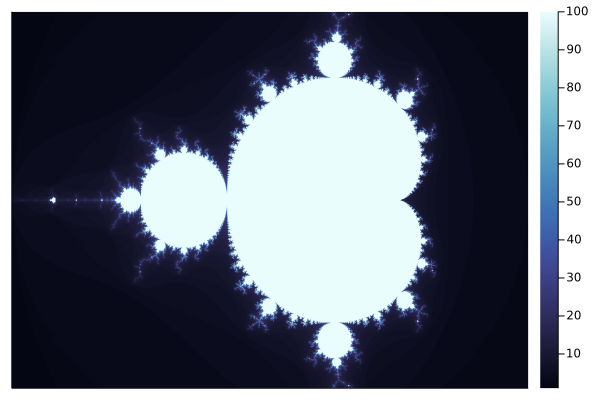

In [44]:
@show plotMandelbrot((-2.0, 1.0), (-1., 1.))

plotMandelbrot((-1.0, 1.0); n = 1000) = Plot{Plots.GRBackend() n=1}


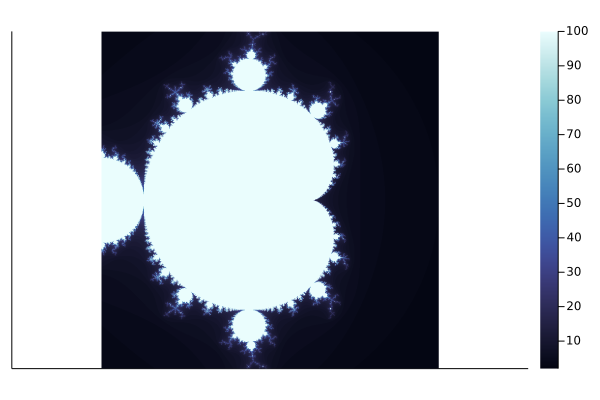

In [45]:
@show plotMandelbrot((-1.,1.); n=1_000 )

plotMandelbrot((-0.9, 0.7), (-0.45, 0.7)) = Plot{Plots.GRBackend() n=1}


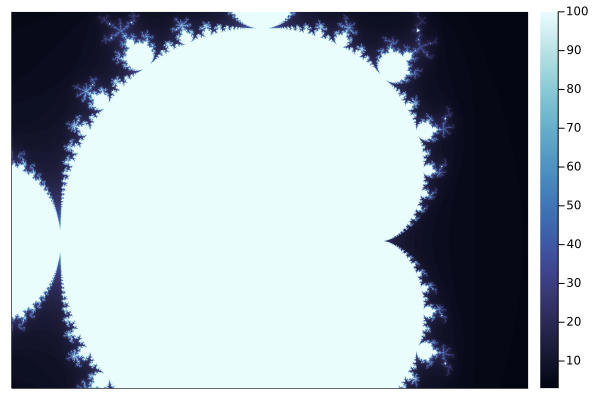

In [46]:
@show plotMandelbrot((-0.9, 0.7), (-0.45, 0.7))

In [47]:
times = zeros(50)
for i in 1:50
    times[i] = @elapsed plotMandelbrot((-1.,1.); n=round(Int,i*10));
end

In [48]:
round(Int, 2) 

2

### KR5 and KR6


In [49]:
times

50-element Vector{Float64}:
 0.000667
 0.0003973
 0.0005109
 0.000729
 0.0010397
 0.0013625
 0.00175
 0.0022105
 0.0033831
 0.0033487
 0.0041383
 0.0048197
 0.005786
 ⋮
 0.0480204
 0.0511537
 0.0531953
 0.0553296
 0.0582424
 0.060813
 0.062968
 0.0670087
 0.0697115
 0.0718466
 0.0743036
 0.0779459

In [50]:
using Pkg
Pkg.add("CurveFit")
using CurveFit

   Resolving package versions...
  No Changes to `C:\Users\admin\Project.toml`
  No Changes to `C:\Users\admin\Manifest.toml`


In [51]:


fit = curve_fit(PowerFit, LinRange(50,500,Int64(50)), times)



PowerFit{Float64}((2.7701803692380354e-8, 2.4019326576753133))

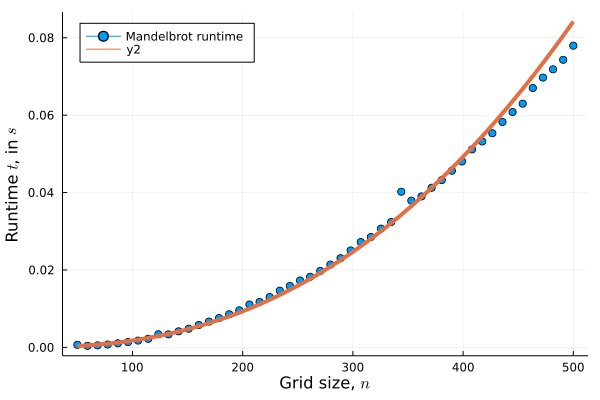

In [52]:
plt = plot(xlabel="Grid size, \$n\$", ylabel = "Runtime \$t\$, in \$s\$", legend=:topleft)
plot!(plt, LinRange(50,500,50), times, linewidth = 0, markershape = :circle, label="Mandelbrot runtime")
plot!(plt, LinRange(50,500,50), fit.(LinRange(50,500,50)), linewidth = 4)

In [53]:
LinRange(50,500,Int64(50))

50-element LinRange{Float64, Int64}:
 50.0,59.1837,68.3673,77.551,86.7347,…,463.265,472.449,481.633,490.816,500.0

We can see from this plot that we can fit an exponential curve with order 2.4. At the tail end of the plot, notice how the curve overshoots a bit. I believe that if we use more data points, the curve will become of order 2. So we can sorta predict how much time Julia takes to render a Mandelbrot Set of order n. 